In [1]:
import os
from glob import glob
import json
import random

In [ ]:
root_dir = '/working/Data/Images/brats_data'
folder_list = glob(f'{root_dir}/*')
print(len(folder_list))
random.shuffle(folder_list)
train_list = folder_list[:int(len(folder_list) * 0.8)]
val_list = folder_list[int(len(folder_list) * 0.8):]
print(len(train_list), len(val_list))

In [ ]:
train_json = []
for folder in train_list:
    fl_path = glob(f'{folder}/*flair.nii.gz')
    t1_path = glob(f'{folder}/*t1.nii.gz')
    t1ce_path = glob(f'{folder}/*t1ce.nii.gz')
    t2_path = glob(f'{folder}/*t2.nii.gz')
    mask_path = glob(f'{folder}/*flair_brainmask.nii.gz')
    train_json.append({'image': [fl_path[0], t1_path[0], t1ce_path[0], t2_path[0]], 'brainmask': mask_path[0]})
with open('./json/train.json', 'w') as f:
    json.dump(train_json, f, indent=4)
val_json = []
for folder in val_list:
    fl_path = glob(f'{folder}/*flair.nii.gz')
    t1_path = glob(f'{folder}/*t1.nii.gz')
    t1ce_path = glob(f'{folder}/*t1ce.nii.gz')
    t2_path = glob(f'{folder}/*t2.nii.gz')
    mask_path = glob(f'{folder}/*flair_brainmask.nii.gz')
    val_json.append({'image': [fl_path[0], t1_path[0], t1ce_path[0], t2_path[0]], 'brainmask': mask_path[0]})
with open('./json/val.json', 'w') as f:
    json.dump(val_json, f, indent=4)

In [1]:
import os, json, wandb, torch
import numpy as np
import torch.nn.functional as F
from monai import transforms, data
from monai.data import DataLoader, DistributedSampler
from monai.utils import set_determinism
from tqdm import tqdm
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import  PatchDiscriminator
import matplotlib.pyplot as plt
import torch.distributed as dist

/working/Project/StableDiffusion/Stable_diffusion/.venv/lib/python3.12/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/working/Project/StableDiffusion/Stable_diffusion/.venv/lib/python3.12/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [5]:
train_json_path = './json/train.json'
with open(train_json_path) as f:
    train_files = json.load(f)
val_json_path = './json/val.json'
with open(val_json_path) as f:
    val_files = json.load(f)
train_batchsize  = 2

transforms_1mm = transforms.Compose(
    [transforms.Spacingd(keys=["image"], pixdim=(1, 1, 1), mode=("bilinear")),
    transforms.Spacingd(keys=["brainmask"], pixdim=(1, 1, 1), mode=("nearest")),
    transforms.SpatialPadd(keys=["image","brainmask"], spatial_size=(160, 160, 128)),
    transforms.CropForegroundd(keys=["image"], source_key="brainmask",allow_smaller=False),
    transforms.DeleteItemsd(keys=["brainmask"]),
    transforms.RandSpatialCropd(keys=["image"], roi_size=(80, 80, 64),max_roi_size = (100, 100, 80), random_size=True),
    transforms.Resized(keys=["image"], spatial_size=(80, 80, 64), size_mode = 'all', mode='bilinear'),
    ]
)
transforms_2mm = transforms.Compose(
    [transforms.Spacingd(keys=["image"], pixdim=(2, 2, 2), mode=("bilinear")),
    transforms.Spacingd(keys=["brainmask"], pixdim=(2, 2, 2), mode=("nearest")),
    transforms.SpatialPadd(keys=["image","brainmask"], spatial_size=(80, 80, 64)),
    transforms.CropForegroundd(keys=["image"], source_key="brainmask",allow_smaller=False),
    transforms.DeleteItemsd(keys=["brainmask"]),
    transforms.Resized(keys=["image"], spatial_size=80, size_mode = 'longest', mode='bilinear'),
    transforms.CenterSpatialCropd(keys=["image"], roi_size=(80, 80, 64)),
    transforms.SpatialPadd(keys=["image"], spatial_size=(80, 80, 64)),
    ]
)
train_transforms = transforms.Compose(
    [
        transforms.CopyItemsd(keys=["image"], names=["path"]),
        transforms.LoadImaged(keys=["image","brainmask"]),
        transforms.EnsureChannelFirstd(keys=["image","brainmask"]),
        transforms.EnsureTyped(keys=["image","brainmask"]),
        transforms.Orientationd(keys=["image","brainmask"], axcodes="RAS"),
        # transforms.RandAffined(
        #     keys=["image","brainmask"],
        #     rotate_range=(-np.pi / 36, np.pi / 36),
        #     translate_range=(-1, 1),
        #     scale_range=(-0.05, 0.05),
        #     padding_mode="zeros",
        #     prob=0.5,
        # ),
        transforms.CropForegroundd(
            keys=["image", "brainmask"],
            source_key="brainmask",
            allow_smaller=False,
        ),
        transforms.ResizeWithPadOrCropd(keys=["image","brainmask"], spatial_size=(192, 192, 141)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0.5, upper=99.5, b_min=0, b_max=1,clip=True ),#, relative=True
        # transforms.OneOf([transforms_1mm, transforms_2mm]),
    ]
)
train_ds = data.Dataset(data=train_files, transform=train_transforms)
# sampler_train = DistributedSampler(train_ds, num_replicas=4, rank=rank)
train_loader = DataLoader(train_ds, batch_size=train_batchsize, shuffle=False, num_workers=8, persistent_workers=True, drop_last=True, sampler=None)

val_transforms = transforms.Compose(
    [
        transforms.CopyItemsd(keys=["image"], names=["path"]),
        transforms.LoadImaged(keys=["image","brainmask"]),
        transforms.EnsureChannelFirstd(keys=["image","brainmask"]),
        transforms.EnsureTyped(keys=["image","brainmask"]),
        transforms.Orientationd(keys=["image","brainmask"], axcodes="RAS"),
        transforms.CropForegroundd(
            keys=["image", "brainmask"],
            source_key="brainmask",
            allow_smaller=False,
        ),
        transforms.ResizeWithPadOrCropd(keys=["image","brainmask"], spatial_size=(192, 192, 141)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0.5, upper=99.5, b_min=0, b_max=1),
        # transforms_2mm,
    ]
)
val_ds = data.Dataset(data=val_files, transform=train_transforms)
# sampler_val = DistributedSampler(val_ds, num_replicas=4, rank=rank)
val_loader = DataLoader(val_ds, batch_size=train_batchsize, shuffle=False, num_workers=8, persistent_workers=True, drop_last=True, sampler=None)

In [3]:
import torch
from diffusers import AutoencoderKLWan
model_id = "Wan-AI/Wan2.1-T2V-14B-Diffusers"
vae = AutoencoderKLWan.from_pretrained(model_id, subfolder="vae", torch_dtype=torch.bfloat16, cache_dir="/working/cache/huggingface/hub")
vae = vae.to("cuda")
vae.eval()

AutoencoderKLWan(
  (encoder): WanEncoder3d(
    (nonlinearity): SiLU()
    (conv_in): WanCausalConv3d(3, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (down_blocks): ModuleList(
      (0-1): 2 x WanResidualBlock(
        (nonlinearity): SiLU()
        (norm1): WanRMS_norm()
        (conv1): WanCausalConv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (norm2): WanRMS_norm()
        (dropout): Dropout(p=0.0, inplace=False)
        (conv2): WanCausalConv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (conv_shortcut): Identity()
      )
      (2): WanResample(
        (resample): Sequential(
          (0): ZeroPad2d((0, 1, 0, 1))
          (1): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (3): WanResidualBlock(
        (nonlinearity): SiLU()
        (norm1): WanRMS_norm()
        (conv1): WanCausalConv3d(96, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (norm2): WanRMS_norm()
        (dropout): Dropout(p=0.0, inplace=False)
 

In [6]:
with torch.no_grad():
    vae.eval()
    for batch in train_loader:
        image = batch['image']
        mask = batch['brainmask']
        path = batch['path']
        image = image.permute(0, 1, 4, 2, 3)  # [B, C, H, W, D] -> [B, D, H, W, C]
        B, C, D, H, W  = image.shape
        print(image.shape)
        image = image.view(B*C, D, H, W)  # [4, 1, D, H, W]
        image = image.unsqueeze(1)
        image = image.repeat(1, 3, 1, 1, 1)  # [4, 3, D, H, W]
        print(image.shape)
        image = image.to(torch.bfloat16).to("cuda")
        encode = vae.encode(image, return_dict=True)
        latent = encode.latent_dist.sample()
        print(latent.shape)
        
        latent = latent.view(B, 64, -1, int(H/8), int(W/8))
        print(latent.shape)
        break

        # decoded = vae.decode(encode.latent_dist.sample(), return_dict=True)
        # save_path = path[0][0].replace('flair.nii.gz', 'vae.pt')
        # save_path = './cache/'+os.path.basename(save_path)
        # torch.save(encode.latent_dist.sample(), save_path)
        # print(save_path)
        # break


torch.Size([2, 4, 141, 192, 192])
torch.Size([8, 3, 141, 192, 192])
torch.Size([8, 16, 36, 24, 24])
torch.Size([2, 64, 36, 24, 24])


In [7]:
temp = latent[0,:,:,:,:]
temp = temp.view(4,16,36,24,24)
with torch.no_grad():
    decoded = vae.decode(temp, return_dict=True)
    print(decoded.sample.shape)

torch.Size([4, 3, 141, 192, 192])


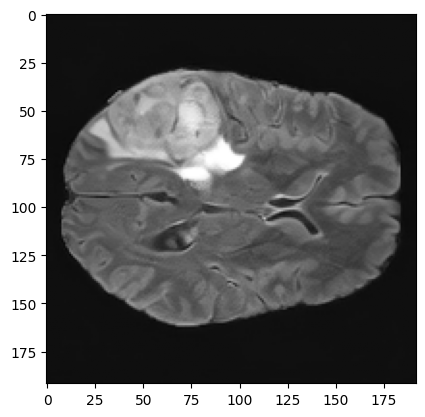

In [11]:
plt.imshow(decoded.sample[0, 2, 72, :, :].cpu().float().numpy(), cmap='gray')